# Portfolio optimization using TMAI API

This notebook demonstrates optimal portfolio rebalancing of a basket of tokens tradable on the Aerodrome dex on the Base network.

It fetches market data using the TokenMetrics sdk and computes weights of the portfolio having the best sharpe ratio using Markowitz's efficient frontier model.

In [3]:
import tmai_api
import numpy as np
import pandas as pd

# Initialize the client with your API key
client = tmai_api.TokenMetricsClient(api_key="tm-08a05f22-ac5c-4d21-ba26-8d57d5831837")

In [4]:
# Get information for top cryptocurrencies
tokens_df = client.tokens.get_dataframe(exchange="aerodrome-base")
# asset_names = tokens_df.head(10)['TOKEN_NAME'].astype(str)
asset_names = ['Bitcoin', 'Ethereum', 'Aerodrome Finance', 'USDC', 'yearn.finance', 'Dickbutt', 'KlimaDAO']

In [5]:
ohlcv = client.daily_ohlcv.get_dataframe(token_name=','.join(asset_names), startDate="2024-01-01", endDate="2025-01-01")

Fetching daily-ohlcv data: 100%|█████████████| 13/13 [00:28<00:00,  2.19s/chunk]


In [6]:
ohlcv

,TOKEN_ID,TOKEN_NAME,TOKEN_SYMBOL,DATE,OPEN,HIGH,LOW,CLOSE,VOLUME
0,2497,KlimaDAO,KLIMA,2024-01-30T00:00:00.000Z,0.798695,0.803942,0.795088,0.799036,2.284963e+04
1,3396,USDC,USDC,2024-01-30T00:00:00.000Z,0.999936,1.002000,0.996867,0.999177,6.087499e+09
2,4253,yearn.finance,YFI,2024-01-30T00:00:00.000Z,7316.790000,7436.000000,7286.370000,7381.560000,1.773469e+07
3,30747,Aerodrome Finance,AERO,2024-01-30T00:00:00.000Z,0.094120,0.098083,0.086046,0.086046,1.436695e+06
4,3375,Bitcoin,BTC,2024-01-30T00:00:00.000Z,43133.000000,43731.000000,43133.000000,43408.000000,2.387392e+10
...,...,...,...,...,...,...,...,...,...
1295,4253,yearn.finance,YFI,2024-12-17T00:00:00.000Z,10748.210000,10752.250000,10084.310000,10084.310000,5.504146e+07
1296,4253,yearn.finance,YFI,2024-12-16T00:00:00.000Z,11008.100000,11448.740000,10606.570000,10826.640000,7.095887e+07
1297,3396,USDC,USDC,2024-12-16T00:00:00.000Z,0.999958,1.008000,0.998080,0.999086,9.731784e+09
1298,3375,Bitcoin,BTC,2024-12-16T00:00:00.000Z,104877.000000,107822.000000,103467.000000,105836.000000,1.278855e+11


In [8]:
data = ohlcv.copy()
data['DATE'] = pd.to_datetime(data['DATE']).dt.date
data = data.groupby(['DATE', 'TOKEN_NAME'])['CLOSE'].last().unstack().bfill()
assets = [asset for asset in asset_names if asset in data.columns]
data = data[assets]
data

TOKEN_NAME,Bitcoin,Ethereum,Aerodrome Finance,USDC,yearn.finance,KlimaDAO
DATE,,,,,,
2024-01-14,42640.0,2515.47,0.046159,1.001000,7895.39,0.870927
2024-01-15,42640.0,2514.24,0.046159,1.000000,7796.59,0.862466
2024-01-16,43269.0,2598.85,0.045154,1.000000,7879.22,0.900156
2024-01-17,42676.0,2526.25,0.042853,1.001000,7821.12,0.891707
2024-01-18,41294.0,2467.52,0.045626,1.001000,7496.96,0.879144
...,...,...,...,...,...,...
2024-12-28,95276.0,3410.29,1.550000,1.001000,8841.06,0.843901
2024-12-29,93210.0,3341.94,1.480000,0.998576,8275.68,0.816312
2024-12-30,92673.0,3357.01,1.410000,1.000000,8272.72,0.799065


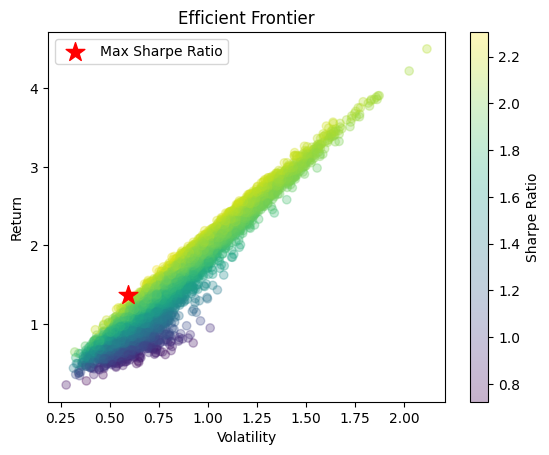

,Asset,Weight
0,Bitcoin,82.94%
1,Ethereum,0.00%
2,Aerodrome Finance,15.97%
3,USDC,0.00%
4,yearn.finance,0.00%
5,KlimaDAO,1.08%


In [9]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Calculate daily returns and covariance matrix
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252  # Annualized returns
cov_matrix = returns.cov() * 252  # Annualized covariance

num_assets = len(assets)

# Random portfolio simulation (Monte Carlo)
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = portfolio_return / portfolio_volatility  # Sharpe ratio

# Identify the optimal portfolio
max_sharpe_idx = np.argmax(results[2])
optimal_return = results[0, max_sharpe_idx]
optimal_volatility = results[1, max_sharpe_idx]

# **Optimization: Find the Efficient Frontier**
def portfolio_performance(weights, mean_returns, cov_matrix):
    """Calculates portfolio return and volatility."""
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, volatility

# **Optimization Functions**
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    returns, volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(returns - risk_free_rate) / volatility  # Minimize negative Sharpe

def minimize_volatility(weights, mean_returns, cov_matrix):
    _, volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return volatility  # Minimize portfolio volatility

# Constraints & Bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights = 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No short-selling
initial_weights = num_assets * [1. / num_assets]

# **Max Sharpe Portfolio**
optimized_sharpe = minimize(negative_sharpe_ratio, initial_weights,
                            args=(mean_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_sharpe = optimized_sharpe.x

# **Min Volatility Portfolio**
optimized_volatility = minimize(minimize_volatility, initial_weights,
                                args=(mean_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_volatility = optimized_volatility.x

# **Plot Efficient Frontier**
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.3)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=200, label='Max Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

# Print optimal weights
pd.DataFrame({'Asset': assets, 'Weight': list(map(lambda w: f"{w*100:.2f}%", optimal_weights_sharpe))})